# MLOps Assignment 4: Model Monitoring

Anusha Bhat
August 7, 2024

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from evidently import Dataset, DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, RegressionPreset
from evidently.ui.workspace import CloudWorkspace
import os
from dotenv import load_dotenv

## Data Ingestion

In [3]:
df = pd.read_csv('data/cancer_reg.csv', encoding = 'utf-8', encoding_errors = 'ignore')

In [4]:
df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [5]:
df.dtypes

avgAnnCount                float64
avgDeathsPerYear             int64
TARGET_deathRate           float64
incidenceRate              float64
medIncome                    int64
popEst2015                   int64
povertyPercent             float64
studyPerCap                float64
binnedInc                   object
MedianAge                  float64
MedianAgeMale              float64
MedianAgeFemale            float64
Geography                   object
AvgHouseholdSize           float64
PercentMarried             float64
PctNoHS18_24               float64
PctHS18_24                 float64
PctSomeCol18_24            float64
PctBachDeg18_24            float64
PctHS25_Over               float64
PctBachDeg25_Over          float64
PctEmployed16_Over         float64
PctUnemployed16_Over       float64
PctPrivateCoverage         float64
PctPrivateCoverageAlone    float64
PctEmpPrivCoverage         float64
PctPublicCoverage          float64
PctPublicCoverageAlone     float64
PctWhite            

In [6]:
# drop columns that contain duplicate information
df_clean = df.drop(columns = ["avgAnnCount", "binnedInc", "MedianAgeMale", "MedianAgeFemale", "PctMarriedHouseholds"])

In [7]:
# dropping the unique identifier
df_clean = df_clean.drop(columns = ['Geography'])

In [8]:
# drop annual deaths since we want to predict death rate 
df_clean = df_clean.drop(columns = ["avgDeathsPerYear"])

In [9]:
# check NAs 
df_clean.isna().sum()

TARGET_deathRate              0
incidenceRate                 0
medIncome                     0
popEst2015                    0
povertyPercent                0
studyPerCap                   0
MedianAge                     0
AvgHouseholdSize              0
PercentMarried                0
PctNoHS18_24                  0
PctHS18_24                    0
PctSomeCol18_24            2285
PctBachDeg18_24               0
PctHS25_Over                  0
PctBachDeg25_Over             0
PctEmployed16_Over          152
PctUnemployed16_Over          0
PctPrivateCoverage            0
PctPrivateCoverageAlone     609
PctEmpPrivCoverage            0
PctPublicCoverage             0
PctPublicCoverageAlone        0
PctWhite                      0
PctBlack                      0
PctAsian                      0
PctOtherRace                  0
BirthRate                     0
dtype: int64

In [10]:
# median imputation for missing values 
cols_with_nans = ['PctSomeCol18_24', 'PctEmployed16_Over', 'PctPrivateCoverageAlone']

for col in cols_with_nans:
    median_val = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_val)

In [11]:
# check imputation worked
df_clean.isna().sum()

TARGET_deathRate           0
incidenceRate              0
medIncome                  0
popEst2015                 0
povertyPercent             0
studyPerCap                0
MedianAge                  0
AvgHouseholdSize           0
PercentMarried             0
PctNoHS18_24               0
PctHS18_24                 0
PctSomeCol18_24            0
PctBachDeg18_24            0
PctHS25_Over               0
PctBachDeg25_Over          0
PctEmployed16_Over         0
PctUnemployed16_Over       0
PctPrivateCoverage         0
PctPrivateCoverageAlone    0
PctEmpPrivCoverage         0
PctPublicCoverage          0
PctPublicCoverageAlone     0
PctWhite                   0
PctBlack                   0
PctAsian                   0
PctOtherRace               0
BirthRate                  0
dtype: int64

In [12]:
# combine PCT cols into new cols of max val category --> reduce multicolinearity 

# PCT columns with their categories 
groups = {
    'Edu18_24': ['PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24', 'PctBachDeg18_24'],
    'Edu25_Over': ['PctHS25_Over', 'PctBachDeg25_Over'],
    'Race': ['PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace'],
    'HealthCoverage': ['PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctPublicCoverageAlone'],
    'Employment': ['PctEmployed16_Over', 'PctUnemployed16_Over']
}

# cleaning category names 
def clean_cat_name(col_name):
    return col_name.replace('Pct', '').replace('18_24', '').replace('25_Over', '').replace('16_Over', '')

# loop through groups and create max value and category columns
for group, cols in groups.items():
    df_clean[f'{group}_MaxCat'] = df_clean[cols].idxmax(axis = 1).apply(clean_cat_name)
    df_clean.drop(columns = cols, inplace = True)

In [13]:
df_clean.dtypes

TARGET_deathRate         float64
incidenceRate            float64
medIncome                  int64
popEst2015                 int64
povertyPercent           float64
studyPerCap              float64
MedianAge                float64
AvgHouseholdSize         float64
PercentMarried           float64
BirthRate                float64
Edu18_24_MaxCat           object
Edu25_Over_MaxCat         object
Race_MaxCat               object
HealthCoverage_MaxCat     object
Employment_MaxCat         object
dtype: object

In [14]:
df_clean.head()

,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,AvgHouseholdSize,PercentMarried,BirthRate,Edu18_24_MaxCat,Edu25_Over_MaxCat,Race_MaxCat,HealthCoverage_MaxCat,Employment_MaxCat
0,164.9,489.8,61898,260131,11.2,499.748204,39.3,2.54,52.5,6.118831,SomeCol,HS,White,PrivateCoverage,Employed
1,161.3,411.6,48127,43269,18.6,23.111234,33.0,2.34,44.5,4.333096,SomeCol,HS,White,PrivateCoverage,Employed
2,174.7,349.7,49348,21026,14.6,47.560164,45.0,2.62,54.2,3.729488,SomeCol,HS,White,PrivateCoverage,Employed
3,194.8,430.4,44243,75882,17.1,342.637253,42.8,2.52,52.7,4.603841,HS,HS,White,PrivateCoverage,Employed
4,144.4,350.1,49955,10321,12.5,0.000000,48.3,2.34,57.8,6.796657,HS,HS,White,PrivateCoverage,Employed


<Axes: >

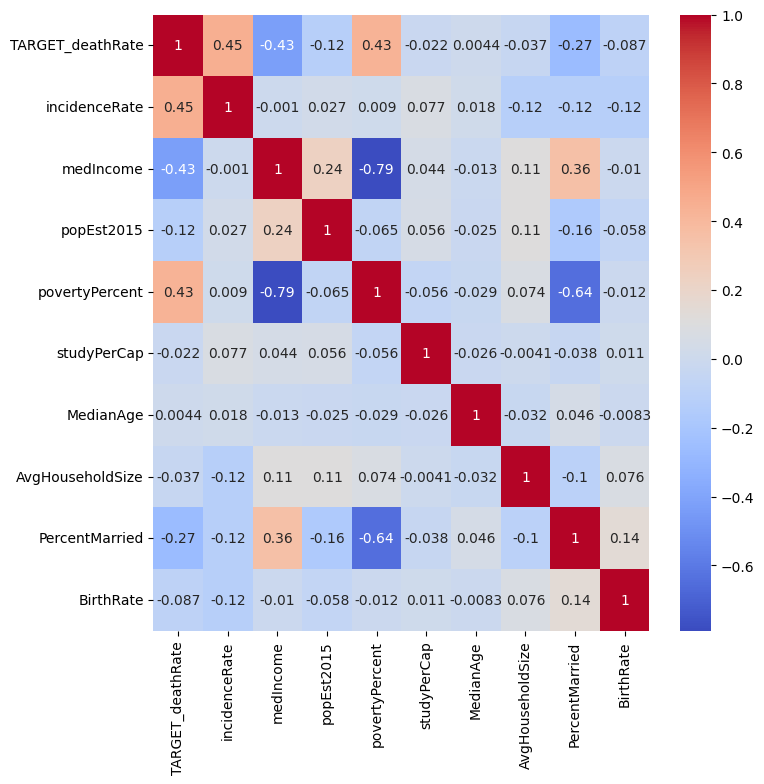

In [15]:
corr = df_clean.corr(numeric_only = True)
plt.figure(figsize = (8,8))
sns.heatmap(corr, cmap = 'coolwarm', annot = True)

The high correlations are between median income and poverty percent, and percent married and poverty percent. Since we need both median income and poverty percent for this assignment we will not drop them. To reduce multicolinearity, we will drop PercentMarried.

In [16]:
df_clean = df_clean.drop(columns = ["PercentMarried"])

## Model Development

### 80-20  Train - Test Split 

In [17]:
# create X and y
X = df_clean.drop(columns = ['TARGET_deathRate'])
y = df_clean['TARGET_deathRate']

# one-hot encode categorical columns (dummies)
cat_cols = ['Edu18_24_MaxCat', 'Edu25_Over_MaxCat', 'Race_MaxCat', 'HealthCoverage_MaxCat', 'Employment_MaxCat']
X = pd.get_dummies(X, columns = cat_cols, drop_first = True)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

### Train & Evaluate Initial XGBoost Model

In [18]:
# Train XGBoost
model = XGBRegressor(random_state = 7, n_jobs = -1)
model.fit(X_train, y_train)

# evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"Original Test RMSE: {rmse:.4f}")

Original Test RMSE: 448.2672


### Update Test Sets 

In [ ]:
X_test_med = X_test.copy()
X_test_pov = X_test.copy()
X_test_size = X_test.copy()

# A: decrease medIncome by 40,000
X_test_med["medIncome"] = X_test["medIncome"] - 40000

# A & B: A + increase povertyPercent by 20
X_test_pov["medIncome"] = X_test["medIncome"] - 40000
X_test_pov["povertyPercent"] = X_test["povertyPercent"] + 20

# A & B & C: A + B + increase AvgHouseholdSize by 2
X_test_size["medIncome"] = X_test["medIncome"] - 40000
X_test_size["povertyPercent"] = X_test["povertyPercent"] + 20
X_test_size["AvgHouseholdSize"] = X_test["AvgHouseholdSize"] + 2

### Evaluate XGBoost Model on New Test Sets 

In [21]:
def evaluate_tests(model, X_test, y_true):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_true, y_pred)
    return (y_pred, rmse)


med_preds, med_rmse = evaluate_tests(model, X_test_med, y_test)
pov_preds, pov_rmse = evaluate_tests(model, X_test_pov, y_test)
size_preds, size_rmse = evaluate_tests(model, X_test_size, y_test)

print(f"Median Income Change Test RMSE: {med_rmse:.4f}")
print(f"Median Income + Poverty Percent Change Test RMSE: {pov_rmse:.4f}")
print(f"Median Income + Poverty Percent + Household Size Change Test RMSE: {size_rmse:.4f}")

Median Income Change Test RMSE: 720.2507
Median Income + Poverty Percent Change Test RMSE: 1392.2992
Median Income + Poverty Percent + Household Size Change Test RMSE: 958.3236


## Model Monitoring with Evidently 

### Connect to Evidently & Setup Project 

In [22]:
load_dotenv()
api_token = os.getenv("evidently_api_token")
org_id_token = os.getenv("evidently_org_id")

# connect to cloud
ws = CloudWorkspace(token = api_token, url="https://app.evidently.cloud")

In [23]:
project = ws.create_project("MLOps: Predicting Cancer Death Rate", org_id = org_id_token)

### Create Dashboards

In [24]:
# define schema 
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['bool', 'uint8']).columns.tolist()

schema = DataDefinition(
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)
ref_dataset = Dataset.from_pandas(X_test, data_definition = schema)
prod_dataset_med = Dataset.from_pandas(X_test_med, data_definition = schema)
prod_dataset_pov = Dataset.from_pandas(X_test_pov, data_definition = schema)
prod_dataset_size = Dataset.from_pandas(X_test_size, data_definition = schema)

In [25]:
# create and run the data drift reports 
report_med = Report([DataDriftPreset()])
snapshot_med = report_med.run(prod_dataset_med, ref_dataset)
snapshot_med.save_html("report_med.html")

report_pov = Report([DataDriftPreset()])
snapshot_pov = report_pov.run(prod_dataset_pov, ref_dataset)
snapshot_pov.save_html("report_pov.html")

report_size = Report([DataDriftPreset()])
snapshot_size = report_size.run(prod_dataset_size, ref_dataset)
snapshot_size.save_html("report_size.html")

In [26]:
# upload snapshots to evidently 
ws.add_run(project.id, snapshot_med, include_data = False)
ws.add_run(project.id, snapshot_pov, include_data = False)
ws.add_run(project.id, snapshot_size, include_data = False)

Report ID: 01988661-4304-7e8f-ac49-aa823443dd73
Link: https://app.evidently.cloud/v2/projects/01988660-f8fc-711c-a99b-c908ee09d803/explore/01988661-4304-7e8f-ac49-aa823443dd73